<a href="https://colab.research.google.com/github/yuchenlichuck/China/blob/master/Project_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Image Classification

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

## Task 1:  Data Loading (10 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [ ]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
print(torch.__version__)
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for testing


data_transforms = {
    'train': transforms.Compose([
      # TODO: Task 1
        #transforms.
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

    ]),
    'test': transforms.Compose([
     # TODO: Task 1
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

# Load CIFAR10

image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=(x=='train'), num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1.6.0+cu101


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

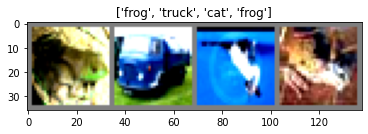

In [ ]:
# TODO Task 1:  Run this cell and try to understand the output of each step

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Task 2: Basic Networks (20 points)
1. Create a Fully connected Network (FcNet) as follows in the Jupyter Notebook:
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the FcNet for **3** epoches and record the training time and accuracy in your final report.

2. Create a Convolutional Network (ConvNet) as follows in the Jupyter Notebook:
```
ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. 

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

### Model training code 

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model

### Model test code 

In [ ]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
           

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return 

### 1) FC Network

In [ ]:
# 1) Define a Fully Connected Neural Network
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        # TODO Task 2:  Define the layers 
        self.fc1=nn.Linear(3072,1024)
        self.fc2=nn.Linear(1024,400)
        self.fc3=nn.Linear(400,84)
        self.fc4=nn.Linear(84,10)

    def forward(self, x):
        # TODO Task 2:  Define the forward pass
#         x=F.relu(self.fc1(x))
#         x=F.relu(self.fc2(x))
#         x=F.relu(self.fc3(x))
        x=x.view(x.size(0),-1)
        x=self.fc1(x)
        x=self.fc2(x)
        x=self.fc3(x)
        x=self.fc4(x)
        return x

    
model_ft = FcNet() #Define the model
model_ft = model_ft.to(device) 
print(model_ft)

# TODO Task 2:  Define loss criterion - cross entropy loss
criterion=nn.CrossEntropyLoss()
# TODO Task 2:  Define Optimizer
optimizer=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
# TODO Task 2:  Train the model
train_model(model_ft,criterion,optimizer,3)
# TODO Task 2:  Test the model
test_model(model_ft)


FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/2
----------
train Loss: 1.9711 Acc: 0.3009
Epoch 1/2
----------
train Loss: 1.9398 Acc: 0.3153
Epoch 2/2
----------
train Loss: 1.9313 Acc: 0.3215

Training complete in 2m 35s
test Acc: 0.3390
Testing complete in 0m 6s


### 2) CNN

In [ ]:
# 2) Define a Convolutional Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # TODO Task 2:  Define the CNN layers 
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(400,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
        
    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x=self.pool(F.relu(self.conv1(x)))
        #x=F.max_pool2d(x,2)
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

model_ft = ConvNet() #Define the model
model_ft = model_ft.to(device)
print(model_ft)

# TODO Task 2:  Define loss criterion - cross entropy loss
criterion=nn.CrossEntropyLoss()
# TODO Task 2:  Define Optimizer
optimizer=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
# TODO Task 2:  Train the model
train_model(model_ft,criterion,optimizer,3)
# TODO Task 2:  Test the model
test_model(model_ft)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 0/2
----------
train Loss: 1.7333 Acc: 0.3605
Epoch 1/2
----------
train Loss: 1.4860 Acc: 0.4594
Epoch 2/2
----------
train Loss: 1.4047 Acc: 0.4968

Training complete in 2m 56s
test Acc: 0.5016
Testing complete in 0m 7s


## Task 3: Design Your Network I (20 points)
Define your own Convolutional Network (MyNet) starting from the configuration in Task 2.2. Add following modifications and train the Network for **25** epoches. Keep the best settings for each step (for each step, record the training accuracy of the last epoch and test accuracy in your report):

1. Modify the number of layers: Modify the number of convolutional layers and number of filters in the network. (Try at least 3 reasonable configurations)
2. Modify the filter sizes in each convolutional layer. Experiment with different filter sizes (3x3, 5x5 and 7x7) or a combination of these.

#### *Bonus Points: Define a validation set within the training set to monitor underfitting/overfitting after every epoch for each task. (Hint modify dataloaders and/or train_model function) 

## Task 4: Design Your Network II (20 points)
Keeping the best settings of Task 3, use **Dropout** in fully connected layers and Batch Normalization (choose a suitable batch size) in convolutional layers. Record the training accuracy of the last epoch and test accuracy in your report.

## Task 5: The Optimizer (20 points)
Keeping the best settings of Task 4, 3 different optimizers (SGD, ADAM and RMSProp) with 3 different learning rates (0.001, 0.01, 0.1) . Plot the loss curves (Training loss vs Training step ) for the 9 cases (Hint: Modify the train_model fuction). 

### Design Your Network

In [ ]:
# ConvNet(
# (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
# (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
# (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
# (fc1): Linear(in_features=400, out_features=120, bias=True)
# (fc2): Linear(in_features=120, out_features=84, bias=True)
# (fc3): Linear(in_features=84, out_features=10, bias=True)
# )
# Define a Convolutional Neural Network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # TODO Task 3 & 4: Design Your Network I & II 
        self.conv1 = nn.Conv2d(3,6,3,padding =1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6,16,5, padding =2)
        self.conv3 =nn.Conv2d(16, 36, 7, padding =3)
        self.conv4 =nn.Conv2d(36, 60, 3)
        self.conv5 = nn.Conv2d(60, 80, 5)
        
        self.fc1=nn.Linear(2000,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        
    def forward(self, x):
        # TODO Task 3 & 4: Design Your Network I & II
        
        x=self.pool(F.relu(self.conv1(x)))
        #x=F.max_pool2d(x,2)
        x=F.relu(self.conv2(x))
        x=F.relu(self.conv3(x))
        #x=self.pool(F.relu(self.conv4(x)))
        x=F.relu(self.conv4(x))
        x=self.pool(F.relu(self.conv5(x)))
        x=x.view(-1,2000)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [ ]:
# Define a Convolutional Neural Network

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # TODO Task 3 & 4: Design Your Network I & II 
        self.conv1 = nn.Conv2d(3,6,3,padding =1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6,16,5, padding =2)
        self.conv3 =nn.Conv2d(16, 36, 7, padding =3)
        self.batchnorm1=nn.BatchNorm2d(36)
        self.conv4 =nn.Conv2d(36, 60, 5)
        self.conv5 = nn.Conv2d(60, 100, 3)
        self.batchnorm2=nn.BatchNorm2d(100)
        self.dropout = nn.Dropout(p=0.5, inplace=True)
        self.fc1=nn.Linear(2500,200)
        self.fc2=nn.Linear(200,10)
        
    def forward(self, x):
        # TODO Task 3 & 4: Design Your Network I & II
        
        x=self.pool(F.relu(self.conv1(x)))
        #x=F.max_pool2d(x,2)
        x=F.relu(self.conv2(x))
        x=F.relu(self.batchnorm1(self.conv3(x)))
        #x=self.pool(F.relu(self.conv4(x)))
        x=F.relu(self.conv4(x))
        x=self.pool(self.batchnorm2(F.relu(self.conv5(x))))
        x=x.view(-1,2500)
        x=F.relu(self.fc1(self.dropout(x)))
        x=self.fc2(x)
        return x

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model

In [ ]:
model_ft = MyNet()
model_ft = model_ft.to(device)


# TODO:  Define loss criterion - cross entropy loss
criterion=nn.CrossEntropyLoss()
# TODO Task 5: The Optimizer
optimizer=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
## Train and evaluate
train_model(model_ft,criterion,optimizer)

test_model((model_ft))


Epoch 0/24
----------


KeyboardInterrupt: ignored

In [ ]:
model_ft = MyNet()
model_ft = model_ft.to(device)


# TODO:  Define loss criterion - cross entropy loss
criterion=nn.CrossEntropyLoss()
# TODO Task 5: The Optimizer
optimizer=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
## Train and evaluate
train_model(model_ft,criterion,optimizer)

test_model((model_ft))


Epoch 0/24
----------
train Loss: 1.7475 Acc: 0.3569
Epoch 1/24
----------
train Loss: 1.4997 Acc: 0.4532
Epoch 2/24
----------
train Loss: 1.3665 Acc: 0.5082
Epoch 3/24
----------
train Loss: 1.2608 Acc: 0.5484
Epoch 4/24
----------
train Loss: 1.1951 Acc: 0.5727
Epoch 5/24
----------
train Loss: 1.1404 Acc: 0.5935
Epoch 6/24
----------
train Loss: 1.0987 Acc: 0.6088
Epoch 7/24
----------
train Loss: 1.0686 Acc: 0.6176
Epoch 8/24
----------
train Loss: 1.0394 Acc: 0.6304
Epoch 9/24
----------
train Loss: 1.0149 Acc: 0.6408
Epoch 10/24
----------
train Loss: 0.9924 Acc: 0.6479
Epoch 11/24
----------
train Loss: 0.9761 Acc: 0.6533
Epoch 12/24
----------
train Loss: 0.9569 Acc: 0.6606
Epoch 13/24
----------
train Loss: 0.9387 Acc: 0.6713
Epoch 14/24
----------
train Loss: 0.9312 Acc: 0.6700
Epoch 15/24
----------
train Loss: 0.9155 Acc: 0.6777
Epoch 16/24
----------
train Loss: 0.9046 Acc: 0.6798
Epoch 17/24
----------
train Loss: 0.8940 Acc: 0.6849
Epoch 18/24
----------
train Loss: 0.8

### Display model predictions

In [ ]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# TODO Diplay your best model predictions

## Task 6: Visualization (10 points)
Visualize feature maps of the first and the last convolutional layer of your final network using **cifar_example.jpg** as input image. Show the visualization in the report.

#### First layer activations
<img src="https://i.imgur.com/kGB9AuP.png" width="400" align="left">

#### Last layer activations

<img src="https://i.imgur.com/qelH05X.png" width="400" align="left">

In [ ]:
#Task 6: Visualization

In [ ]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [ ]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
inputs = transfer_single_img_to_tensor('example_imgs/cifar_example.jpg') # Loads an image and normalizes it
model_ft.eval()
with torch.no_grad():
   # TODO: Retrive the first and the last layer feature maps of your best model. (Hint: Move back to CPU)

SyntaxError: ignored

In [ ]:
# Visualize the feature maps
out = torchvision.utils.make_grid(# TODO: feaure map 1)
feature_imshow(out)

SyntaxError: ignored

In [ ]:
out = torchvision.utils.make_grid(# TODO: feaure map 2)
feature_imshow(out)

SyntaxError: ignored